In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

import warnings

warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('/content/bank.csv')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


# **1. DATA PREPROCESSING AND EXPLORATION**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [ ]:
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


# **2. DESCRIPTIVE STATISTICS FINDINGS:**


**2.1. DESCRIBING THE NUMERICAL FEATURES**
  - i see that most of the features are well distributed with no outliers
  - this is indicated by the relatively small standard deviation
  - the exception however is the duration feature which has quite a high standard deviation which indicates high data variability
  - i also see that the features are in different scales i.e. age in scale of 1-100, while pdays is in scale 100-999.
  - this can cause value domination during model training, which can cause a non-robust model, i will therefore later bring them to a single standard scale using standard scaler

In [ ]:
# descriptive statistics
df.select_dtypes(include=['int64', 'float64']).describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


**2.2. DESCRIBING THE NON-NUMERICAL FEATURES THROUGH RAW STATISTICS AND VIZUALIZATIONS**


In [ ]:
df.select_dtypes(include=['object']).describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


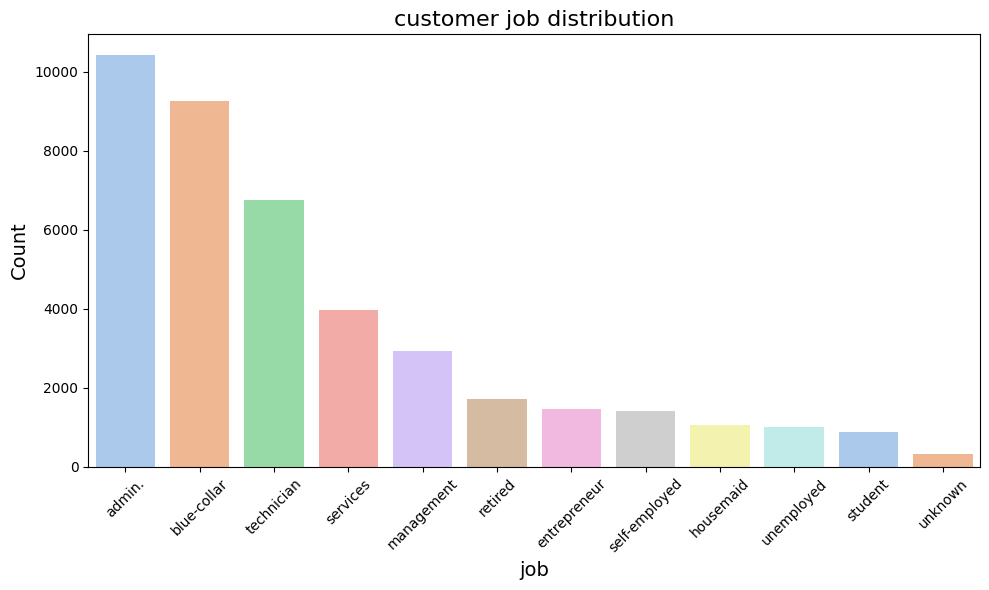

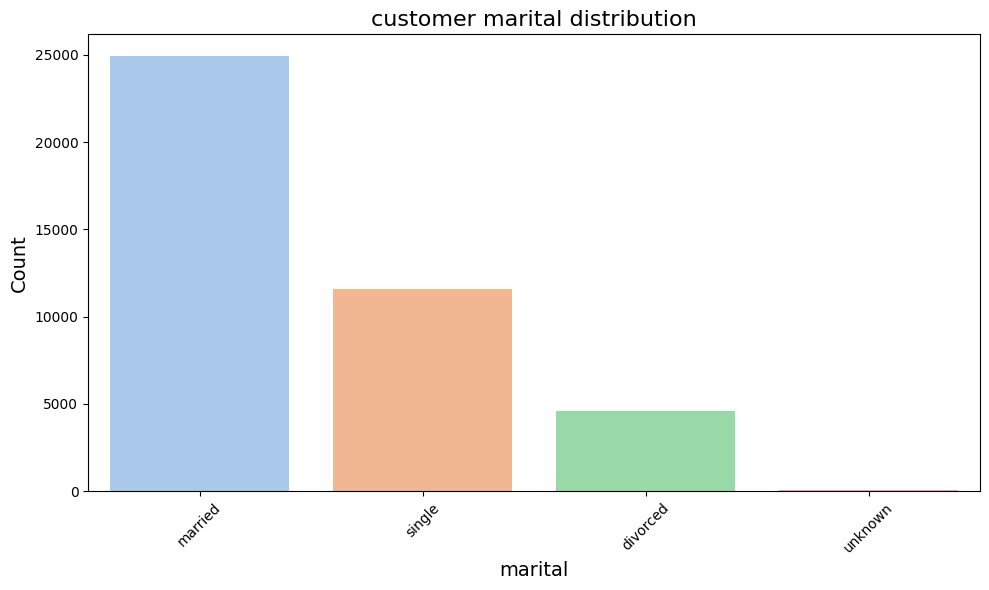

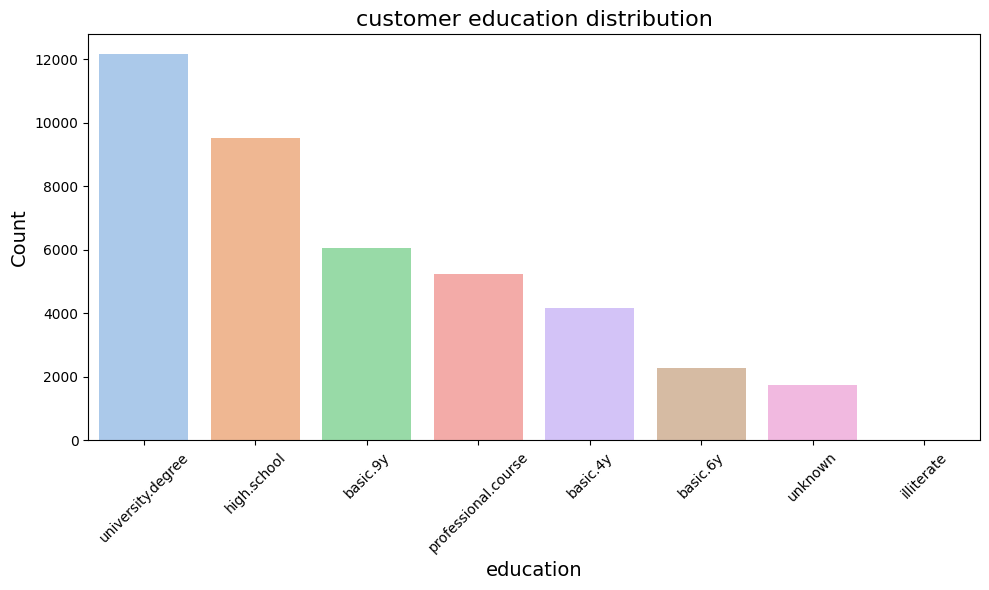

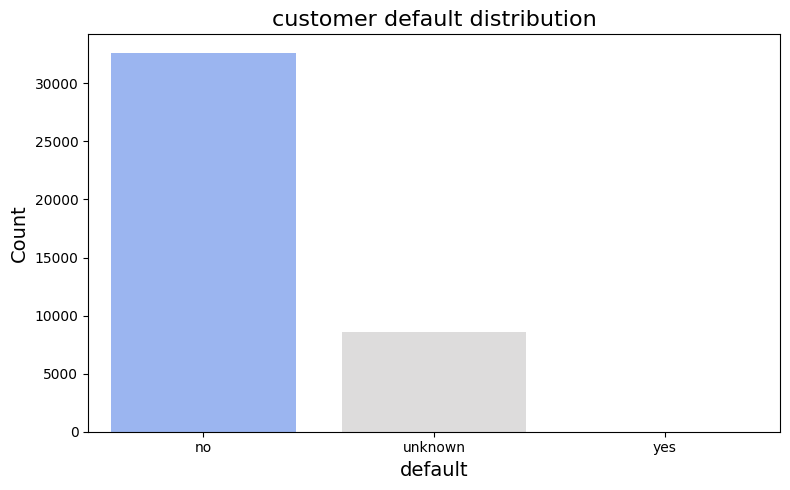

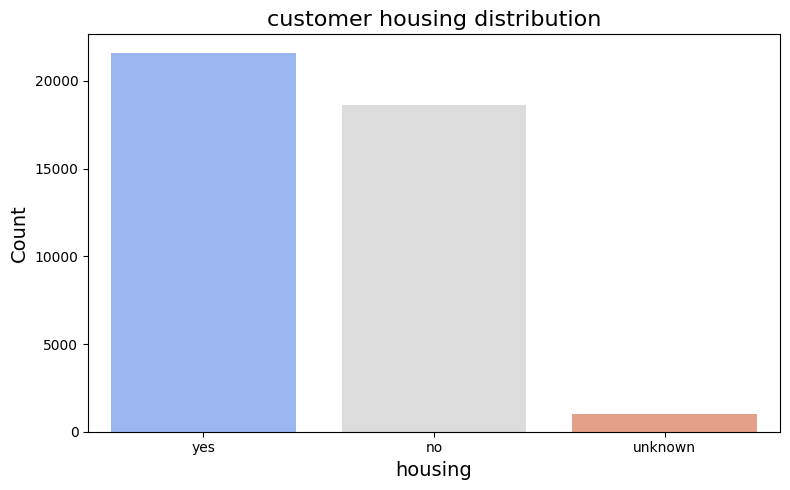

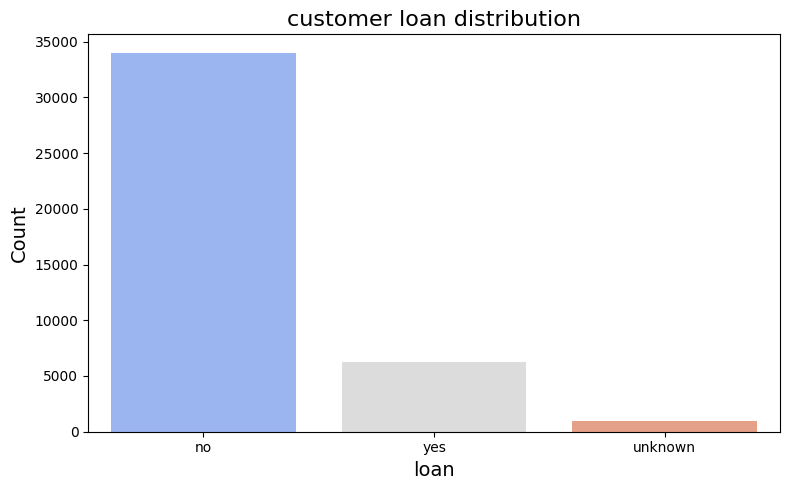

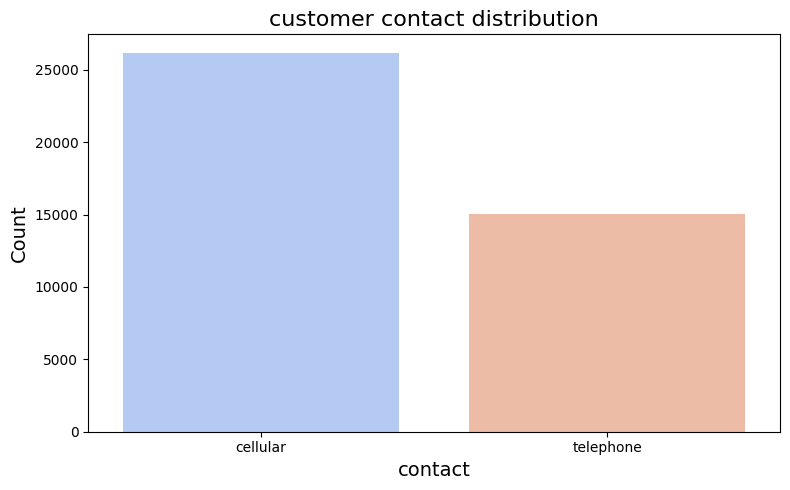

In [ ]:
cols = df.select_dtypes(include='object').drop(['month', 'day_of_week','poutcome'], axis=1)
val_size = cols.nunique()

for col in cols:
  counts = df[col].value_counts()
  if (val_size[col] < 4):
    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')
    plt.title(f'customer {col} distribution', fontsize=16)
    plt.xlabel(f'{col}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print(" \n")
  else:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values, palette='pastel')
    plt.title(f'customer {col} distribution', fontsize=16)
    plt.xlabel(f'{col}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print(" \n \n")


# **3. DATA TRANSFORMATION**
1. convert campain duration from seconds to days

In [ ]:
df.select_dtypes(include=['int64', 'float64']).head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1


In [ ]:
# might have to drop the duration cell
df['duration_minutes'] = df['duration'] // 60
df.select_dtypes(include=['int64', 'float64']).head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,duration_minutes
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0,3
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0,2
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1,5
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0,3
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1,2


# **4. FEATURE SELECTION**

**4.1. SELECTING NUMERIC FEATURES USING PEARSON METHOD**
  - a high correlation score of 1 between two features indicates that they are the same feature
  - a score of 0.80 and -0.85 indicates that the features are possibly duplicates but we need to perform more tests to confirm
  - if the features are correlated then we choose one of the features and drop the other based on which best represent the dataset
  -------------------------------------------------------------------------
  -------------------------------------------------------------------------

  - i can see that the following feature pair pass the correlation threshold:
  1. emp_var_rate and euribo3m with score of 0.97
  2. emp_var_rate and nr_employed with score of 0.91
  3. euribo3m and nr_employed with score 0.95

  - i investigate the relationship before deciding which to drop


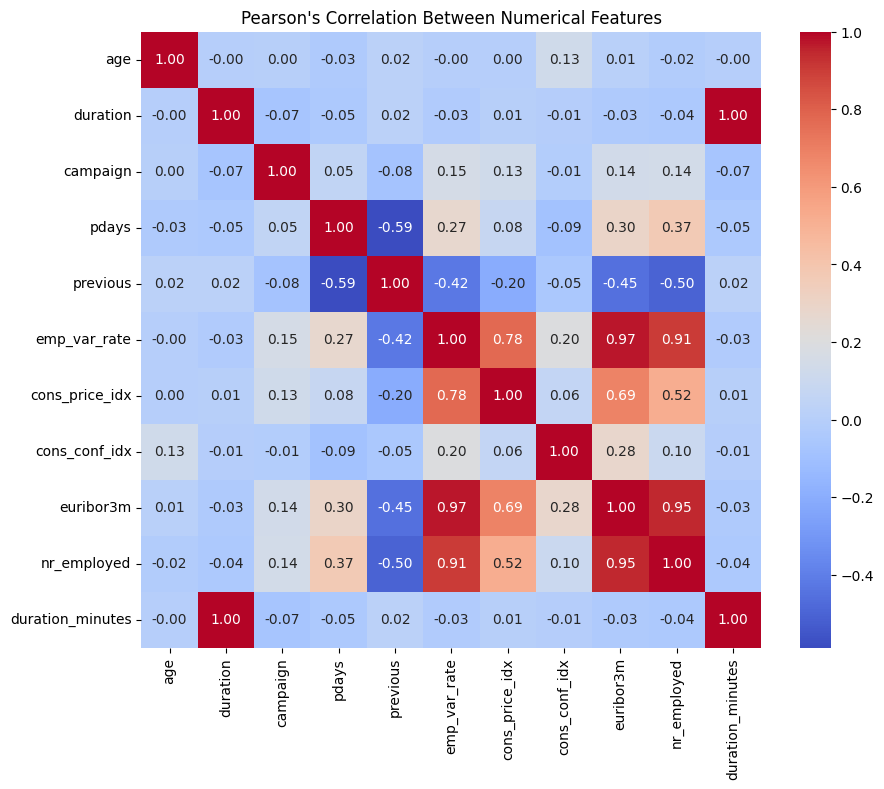

In [ ]:
numeric_corr = df.select_dtypes(include=['int64', 'float64']).drop(columns=['y']).corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Pearson's Correlation Between Numerical Features")
plt.show()

In [ ]:
df[['emp_var_rate','euribor3m', 'nr_employed']].head()

,emp_var_rate,euribor3m,nr_employed
0,1.4,4.963,5228.1
1,-0.1,4.021,5195.8
2,-1.7,0.729,4991.6
3,-1.8,1.405,5099.1
4,-2.9,0.869,5076.2


In [ ]:
# my reasons for dropping these columns:
# emp_var_rate and euribor3m are basically rates indicating economic performance so i arbitrarily chose first
df = df.drop('emp_var_rate', axis=1)

In [ ]:
df = df.drop('nr_employed', axis=1)

In [ ]:
df = df.drop('duration', axis=1)

**4.2. FEATURE SELECTION FOR NON-NUMERIC FEATURES USING CRAMER V METHOD**
  - there are no features that surpass the 0.85 score therefore no categorical features are dropped

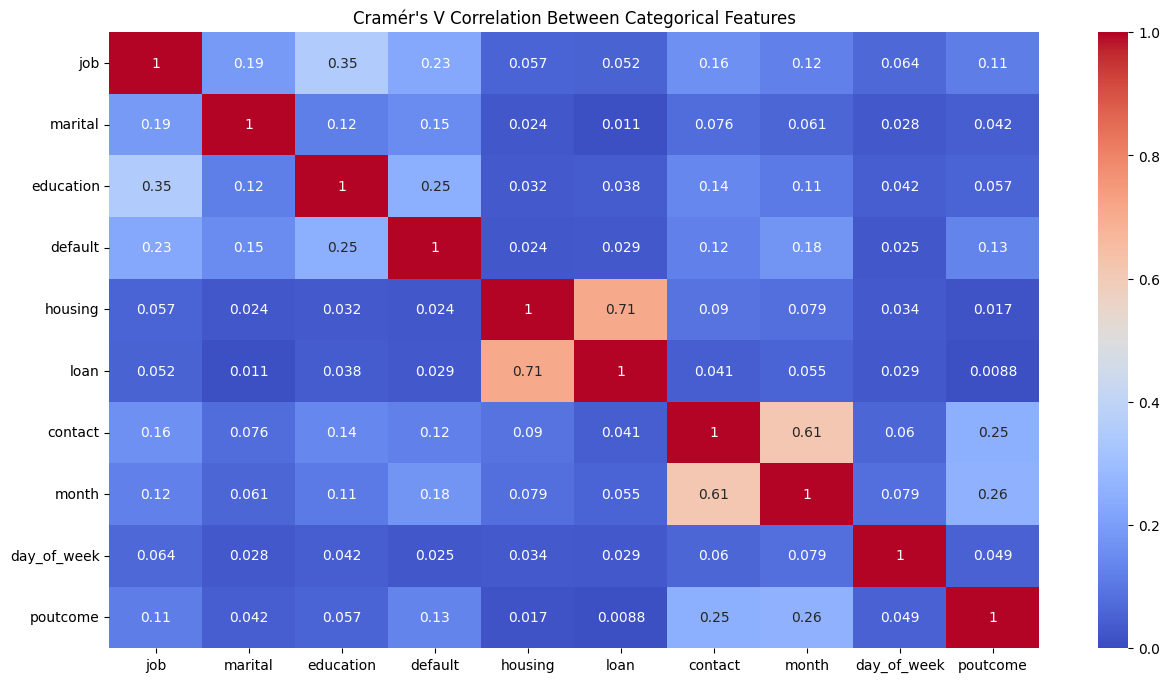

In [ ]:
df_sample = df.sample(frac=0.1, random_state=42)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_columns = df_sample.select_dtypes(include=['object']).columns
cramers_results = pd.DataFrame(index=cat_columns, columns=cat_columns)

for col1 in cat_columns:
    for col2 in cat_columns:
        cramers_results.loc[col1, col2] = cramers_v(df_sample[col1], df_sample[col2])

cramers_results = cramers_results.astype(float)

plt.figure(figsize=(15, 8))
sns.heatmap(cramers_results, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Between Categorical Features")
plt.show()


In [ ]:
# confirming the new features
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons_price_idx,cons_conf_idx,euribor3m,y,duration_minutes
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,93.444,-36.1,4.963,0,3
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,93.200,-42.0,4.021,0,2
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,94.055,-39.8,0.729,1,5
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,93.075,-47.1,1.405,0,3
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,1,3,1,success,92.201,-31.4,0.869,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,1,999,0,nonexistent,94.465,-41.8,4.866,0,3
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,2,999,0,nonexistent,93.994,-36.4,4.860,0,3
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,3,999,0,nonexistent,93.994,-36.4,4.857,0,1
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,2,999,0,nonexistent,92.431,-26.9,0.742,0,3


# **5. FEATURE ENCODING - CONVERTING CATEGORICAL FEATURES INTO NUMERICAL FEATURES**

In [ ]:
X = df.drop('y', axis=1)
Y = df['y']

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [ ]:
X.head()

,age,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,duration_minutes,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,1,999,0,93.444,-36.1,4.963,3,True,False,...,False,False,False,False,False,True,False,False,True,False
1,53,1,999,0,93.200,-42.0,4.021,2,False,False,...,False,True,False,False,False,False,False,False,True,False
2,28,3,6,2,94.055,-39.8,0.729,5,False,False,...,False,False,False,False,False,True,False,False,False,True
3,39,2,999,0,93.075,-47.1,1.405,3,False,False,...,False,False,False,False,False,False,False,False,True,False
4,55,1,3,1,92.201,-31.4,0.869,2,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=8)

In [ ]:
print(f"{X_train.shape} {X_test.shape} {Y_train.shape} {Y_test.shape}")

(32950, 51) (8238, 51) (32950,) (8238,)


# **6. FEATURE STANDARDIZATION - BRINGING NUMERICAL FEATURES INTO ONE SCALE**

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scale, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scale, columns=X_train.columns)

In [ ]:
X_train_scaled_df.head()

,age,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,duration_minutes,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-1.154377,-0.564266,0.195415,-0.347930,-1.181784,-1.232514,-1.367563,0.497994,-0.535404,-0.193146,...,1.412124,-0.331814,-0.13113,-0.116337,-0.509372,-0.516264,-0.494968,-0.493542,0.396787,-0.185666
1,0.286262,-0.564266,0.195415,1.669368,-1.181784,-1.232514,-1.362374,-0.649080,-0.535404,5.177442,...,1.412124,-0.331814,-0.13113,-0.116337,-0.509372,-0.516264,-0.494968,-0.493542,-2.520244,-0.185666
2,0.382305,5.529422,0.195415,-0.347930,0.591621,-0.473076,0.773314,-0.878495,1.867750,-0.193146,...,-0.708153,-0.331814,-0.13113,-0.116337,-0.509372,-0.516264,-0.494968,2.026169,0.396787,-0.185666
3,-1.058334,0.152639,0.195415,-0.347930,0.723112,0.893912,0.713349,0.497994,-0.535404,-0.193146,...,1.412124,-0.331814,-0.13113,-0.116337,-0.509372,-0.516264,-0.494968,-0.493542,0.396787,-0.185666
4,-1.058334,-0.205814,0.195415,1.669368,-1.181784,-1.232514,-1.349689,0.497994,1.867750,-0.193146,...,1.412124,-0.331814,-0.13113,-0.116337,-0.509372,-0.516264,-0.494968,2.026169,-2.520244,-0.185666


# **7. MODEL SELECTION,TRAINING, AND EVALUATION**
1. Logistic regression
2. Decision trees classifiers
3. Random forest trees classifiers
4. Naive Bayes classifiers

**7.1. CROSS-VALIDATION ANALYSIS**
  - the best model is Random forest classifier, followed by Logistic classifier
  - Naives classfier is the worst
  - all the models have low bias and variance which indicates they are not overfitting or underfitting the data

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naives Bayes': GaussianNB()
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled_df, Y_train, cv=5)
    print(f"{model_name}")
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.3f}")

    model.fit(X_train_scaled_df, Y_train)
    y_pred = model.predict(X_test_scaled_df)

    bias = np.mean(y_pred) - np.mean(Y_test)
    variance = variance = np.var(y_pred)

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(Y_test, y_pred))
    print(f"Bias for {model_name}: {bias:.4f}")
    print(f"Variance for {model_name}: {variance:.4f}")
    print("=" * 50)

Logistic Regression
Cross-Validation Scores: [0.91229135 0.90849772 0.90986343 0.90880121 0.90880121]
Mean CV Score: 0.910

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7315
           1       0.67      0.39      0.49       923

    accuracy                           0.91      8238
   macro avg       0.80      0.68      0.72      8238
weighted avg       0.90      0.91      0.90      8238

Bias for Logistic Regression: -0.0461
Variance for Logistic Regression: 0.0616
Decision Tree
Cross-Validation Scores: [0.88937785 0.88664643 0.89150228 0.89028832 0.89347496]
Mean CV Score: 0.890

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7315
           1       0.50      0.54      0.52       923

    accuracy                           0.89      8238
   macro avg       0.72      0.73      0.73 

8. FINAL TRAINING OF THE BEST MODEL ON THE WHOLE DATASET
- since random forest is the best, i tune the hyperparameters to find the best parameters to train the final model on

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_df, Y_train)

print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
best_rf = RandomForestClassifier(random_state=3)

# Train the model on the entire training data
best_rf.fit(X_train_scaled_df, Y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model performance on the test set
print("Classification Report for Random Forest:")
print(classification_report(Y_test, y_pred))

# Calculate the accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")



Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      7315
           1       0.17      0.56      0.26       923

    accuracy                           0.64      8238
   macro avg       0.54      0.60      0.51      8238
weighted avg       0.84      0.64      0.71      8238

Accuracy on the test set: 0.64


# **9. Explaining the models prediction by feature importance analysis**

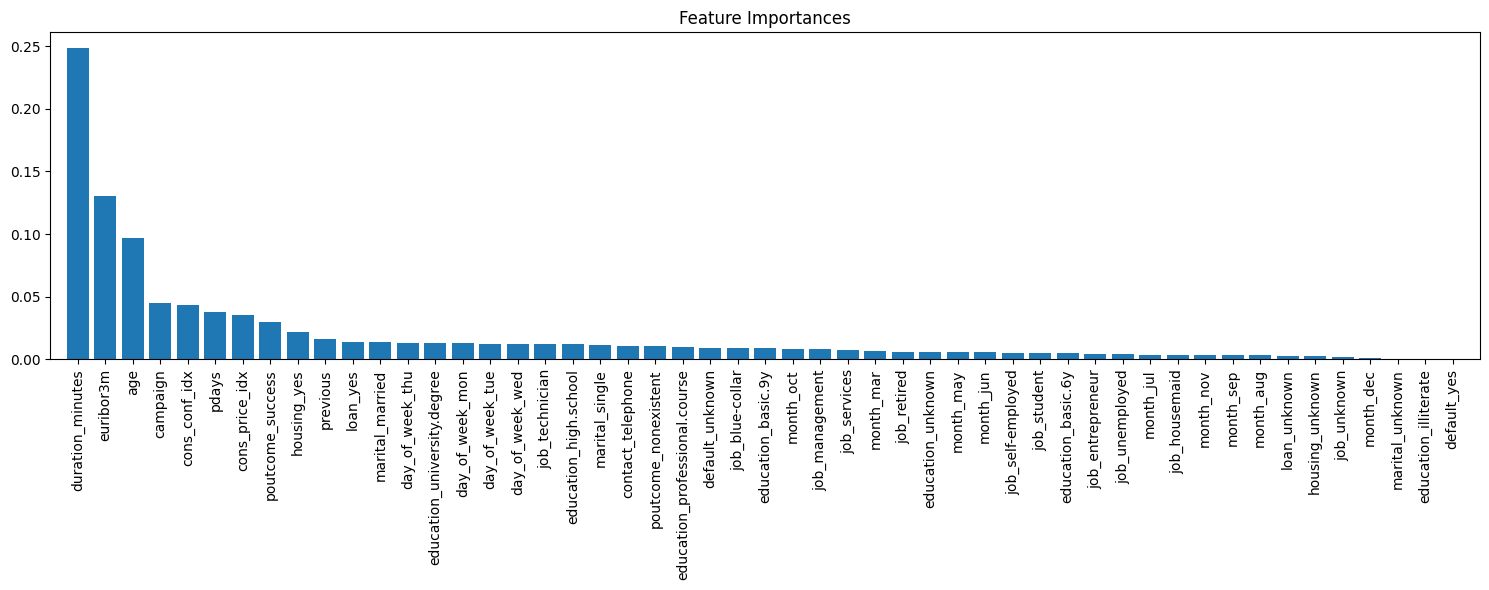

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()